In [7]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, stats , constants
from scipy.optimize import curve_fit
from uncertainties import ufloat, unumpy

In [8]:
Eu = np.loadtxt('./data/Eu1.txt')
Cs = np.loadtxt('./data/Cs2.txt')
Ba = np.loadtxt('./data/Ba3.txt')
St = np.loadtxt('./data/Stone4.txt')

# Klasse die Spektroskopie analysiert

In [9]:
class makeSpek:
    """
    __init__(data, scale=1.):
    
    corPeak(newPeaks):
    
    setScale(newScale):
    
    plot(title='Bitte noch einen Title einfügen', pathToSave='Test'):
    
    plotSector(smin, smax, title="test", plotStyle=plt.plot, show = True):
    
    percentWidth(width, smin, smax, title="test", plotStyle=plt.plot):
    """
    def __init__(self, data, scale=1., bios=0.):
        """Search for Peaks in spektrum, create a x-Axis with scalefactor and save them in peak"""
        self.data = data
        self.scale = scale
        self.bios = bios
        self.hits = np.array([])
        self.xaxis = scale*np.linspace(0, len(data)-1, len(data))+ self.bios
        peaks = np.array(signal.find_peaks_cwt(vector=data, widths=np.arange(2,200), min_snr=8))
        self.peak = unumpy.uarray([self.xaxis.astype(float)[peaks],data[peaks]],[np.zeros(len(peaks)),np.zeros(len(peaks))])
    
    def corPeak(self, newPeaks):
        """Correct not right detected peaks by hand
        Parameters:
            newPeaks = ndarray
                    should include the new Peaks
        """
        self.peak = newPeaks
        if (self.peak.size>2):
            mask = np.argsort(self.peak[0,:])
            self.peak = np.array([self.peak[0,mask],self.peak[1,mask]])
            
    
    def setScale(self, newScale, newBios=0.):
        """Chance the default Scale"""
        self.scale = newScale
        self.bios = newBios
        self.xaxis = newScale*self.xaxis+self.bios
        self.peak[0] = newScale*self.peak[0]+self.bios
        
    def plot(self, pathToSave="Test",title="Bitte noch einen Title einfügen", scale='linear'):
        """Plot the Spektrum with the Maxima"""
        plt.plot(unumpy.nominal_values(unumpy.nominal_values(self.xaxis)), unumpy.nominal_values(self.data), label='Spektrum')
        plt.scatter(unumpy.nominal_values(self.peak[0]), unumpy.nominal_values(self.peak[1]), label='Fit Peaks')
        plt.title(r'Spektrum von $%s$' %title)
        plt.yscale(scale)
        plt.xlim(min(unumpy.nominal_values(self.xaxis))-10,max(unumpy.nominal_values(self.xaxis))+10)
        plt.ylim(-30,max(self.data)*1.1)
        plt.xlabel('Energie in keV')
        plt.ylabel('Counts')
        plt.legend(loc='best')
        plt.grid()
        plt.savefig('./build/Spekt%s.pdf' % pathToSave)
        plt.show()
    
    def plotSector(self, smin, smax, title="test", plotStyle=plt.plot, show = True):
        """ make a plot of the define zone in plot style
        Parameters:
            smin = array_like shape=(1,) 
                    low limit of energie
            smax = array_like shape=(1,)
                    high limit of enegie
            title = string
                    string of Title
            plotType = methode(plt.plot, plt.scatter)
                    how should the data pictured
            show = boolean default:True
                    should the plot show in the function ? true/false
        """
        plt.title(r'%s' %title)
        self.arange = np.arange(int(smin/self.scale), int(smax/self.scale))
        plotStyle(self.xaxis[self.arange], self.data[self.arange],label='Detektiertes Signal')
        plt.xlim(min(self.xaxis[self.arange]), max(self.xaxis[self.arange]))
        plt.ylim(0,max(self.data[self.arange])*1.3)
        plt.xlabel('Energie in keV')
        plt.ylabel('Counts')
        plt.legend(loc='best')
        if (show == True):
            plt.show()
    
    def percentWidth(self, width, smin, smax, title="test", pathToSave="Test", plotStyle=plt.plot):
        """ calculate the width-worth plot the and give the width back
        Parameters:
            smin = array_like shape=(1,) 
                    low limit of energie
            smax = array_like shape=(1,)
                    high limit of enegie
            title = string
                    string of Title
            plotType = methode(plt.plot, plt.scatter)
                    how should the data pictured
        Returns:
            width = scalar
                    the width of the Peak
        """
        self.plotSector(smin, smax, title, plotStyle, show=False)
        wHeight = np.array(max(self.data[self.arange])/width)
        self.mPeak = self.xaxis[self.arange][self.data[self.arange] == max(self.data[self.arange])]
        mask = self.xaxis <= self.mPeak
        Schnittpunkt= np.array([])
        for i in [~mask, mask]:
            newData = self.data[i] 
            newXaxis = self.xaxis[i]
            dist = np.abs(self.data[i]-wHeight)
            x = newXaxis[dist.argsort()[:2]]
            y = newData[dist.argsort()[:2]]
            steigung = (y[1]-y[0])/(x[1]-x[0])
            f = np.poly1d([steigung,wHeight-y[0]])
            Schnittpunkt = np.append(Schnittpunkt, x[0]-np.roots(f)) 
            plt.plot((x[0]-np.roots(f), x[0]-np.roots(f)), (wHeight, 0), 'r--')
        print('Die', width, 'Wertsbreite beträgt : ',np.abs(np.diff(Schnittpunkt)))
        plt.plot((min(self.xaxis[self.arange]), max(self.xaxis[self.arange])), (wHeight, wHeight), 'k--')
        plt.savefig('./build/%sWertsbreite.pdf' % pathToSave)
        plt.show()
        return np.abs(np.diff(Schnittpunkt))
    
    def stdGaus(self, plot=False):
        """Fit a gaussian distritubution through the meassurments. Calculates the hits in one Event and the standard devitation
        Parameters:
            plot = Boolean
                information about the presentation of the Data. True = plot data with fit, False = calculate std of width of distribution
        Returns:
            ---
        """
        for a in unumpy.nominal_values(self.peak[0]):
            self.arange = np.arange(int(a/self.scale-10), int(a/self.scale+10))
            wHeight = max(self.data[self.arange])
            self.mPeak = self.xaxis[self.arange][self.data[self.arange] == max(self.data[self.arange])]
            def gaus(x,a,x0,sigma):
                return a*np.exp(-(x-x0)**2/(2*sigma**2))
            params, cov = curve_fit(gaus,self.xaxis[self.arange],self.data[self.arange], p0=(wHeight, self.mPeak, 1))
            std = np.sqrt(np.diag(cov))
            self.peak[unumpy.nominal_values(self.peak)==a]= ufloat(a, params[2])
            self.hits= np.append(self.hits, np.sqrt(2*np.pi)*ufloat(params[2],std[2])*ufloat(params[0], std[0])/self.scale)
            if (plot==True):
                print('Amplitude: ', params[0], '+-', std[0], 'Verschiebung: ', params[1], '+- ', std[1], 'sigma: ', params[2], '+- ', std[2])
                x = np.linspace(min(self.xaxis[self.arange]),max(self.xaxis[self.arange]), 50)
                print(self.data[self.arange])
                plt.plot(x, gaus(x, *params))
                plt.scatter(self.xaxis[self.arange], self.data[self.arange])
                plt.show()
            

# Eichung des Versuches

Search for the channels from the spectrum to calibrate the x-axis.

[[403.0+/-1.5287992475752676 803.0+/-1.744968213871225
  1128.0+/-1.7357004743498838 1345.0+/-2.220221157881615
  1452.0+/-2.0013311710793404 2544.0+/-2.3810158254962386
  2832.0+/-2.738448908893481 3147.0+/-2.4931787006359
  3543.0+/-2.4737585797921398 3629.0+/-2.4200387624268327
  4593.0+/-2.471603998223638]
 [3078.0+/-0 485.0+/-0 1048.0+/-0 79.0+/-0 112.0+/-0 193.0+/-0 61.0+/-0
  132.0+/-0 88.0+/-0 108.0+/-0 134.0+/-0]]


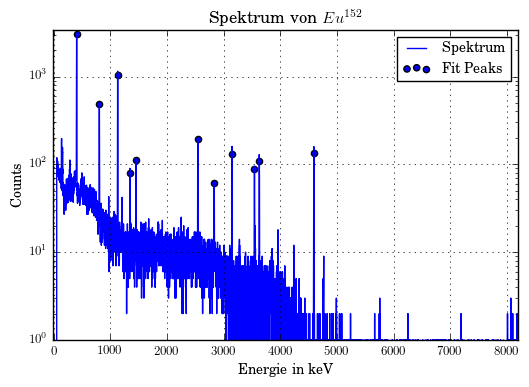

In [10]:
#Task a
EU = makeSpek(Eu)
EU.setScale(1)
mask = np.ones(len(EU.peak[0]), dtype=bool)
mask[-3:-1]=False
EU.corPeak(EU.peak[:,mask])
EU.stdGaus()
print(EU.peak)
EU.plot('Eu','Eu^{152}', 'log')

Regression for scaling.

Steigung a:  0.306979+/-0.000026
y-Achsenabschnitt b:  -1.91+/-0.06
Kanäle:  [403.0+/-1.5287992475752676 803.0+/-1.744968213871225
 1128.0+/-1.7357004743498838 1345.0+/-2.220221157881615
 1452.0+/-2.0013311710793404 2544.0+/-2.3810158254962386
 2832.0+/-2.738448908893481 3147.0+/-2.4931787006359
 3543.0+/-2.4737585797921398 3629.0+/-2.4200387624268327
 4593.0+/-2.471603998223638]


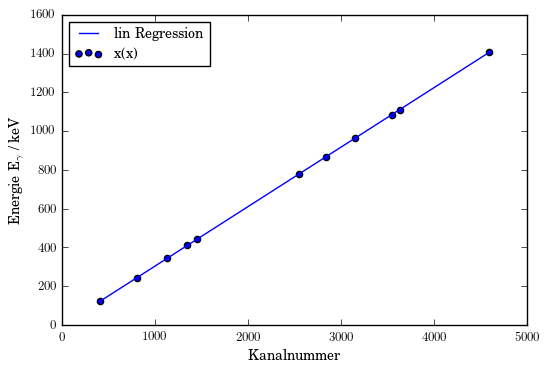

In [11]:
EGamma = np.array([121.7, 244.7, 344.3, 411.12, 443.9, 778.9, 867.37, 964.08, 1085.90, 1112.10, 1408.00])
def linReg(x, a, b):
    return a*x + b
params, cov = curve_fit(linReg, unumpy.nominal_values(EU.peak[0,:]), EGamma, sigma=unumpy.std_devs(EU.peak[0]))
std = np.sqrt(np.diag(cov))
caliBios = ufloat(params[1], std[1])
caliAscent = ufloat(params[0], std[0])
scaleing = params[0]
print('Steigung a: ',caliAscent)
print('y-Achsenabschnitt b: ', caliBios)
print('Kanäle: ', EU.peak[0])
plt.scatter(unumpy.nominal_values(EU.peak[0,:]), EGamma, label=r'x(x)')
plt.plot(unumpy.nominal_values(EU.peak[0,:]), linReg(unumpy.nominal_values(EU.peak[0,:]), *params), label='lin Regression')
plt.xlabel('Kanalnummer')
plt.ylabel(r'Energie E$_{\gamma}$ / keV')
plt.legend(loc='best')
plt.savefig('./build/CsReg.pdf')
plt.show()

Spectrum with calibrate axis.

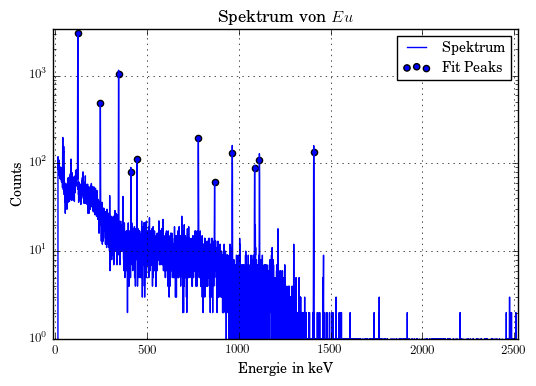

[12187.773813323116+/-277.7248851750456
 2183.584320034194+/-105.7240803994745 5054.970017440959+/-75.3489088997635
 439.53825759330414+/-57.54112715666882
 515.5326437869068+/-57.49499428812106
 1119.2943710819857+/-52.89547048329562
 416.5551980556494+/-38.07800926531355
 960.9805488140645+/-42.48460021005788
 581.6584229158669+/-41.86909065373432
 773.0133195522346+/-34.78060277583312
 899.9730785201976+/-35.78112831371131]


In [12]:
EU.setScale(caliAscent, caliBios)
EU.plot('Eu^{152}','Eu','log')
print(EU.hits)

In [13]:
from uncertainties import unumpy as un
aktEu = un.uarray(4130, 60)
halbEu = un.uarray(4943, 5) # in Tagen
tDiff = 365*16+98 # in Tagen
print("Zeitdifferenz der Vermussung bei Euchung und versuchsentnahme: ", tDiff, " Tage")
def aktNachTagen(t, akt, halbWz):
    return akt*un.exp(-(np.log(2)/halbWz)*t)
AktEu = aktNachTagen(tDiff, aktEu, halbEu)
print('Aktivität: ', AktEu)
distance = ufloat(0.088,0.0003)
Raumwinkel = 2*np.pi*(1-distance/(np.sqrt(distance.nominal_value**2+0.0225**2)) )# strenggenommen darf die näherung nur für a > 10cm benutzt werden
print("Raumwinkel: ", Raumwinkel)
print("Noch einmal Gaußsche Fehlerfortpfalnzung per Hand durchführen !!!!!!!!!!!!!!")

Zeitdifferenz der Vermussung bei Euchung und versuchsentnahme:  5938  Tage
Aktivität:  1796+/-26
Raumwinkel:  0.196+/-0.021
Noch einmal Gaußsche Fehlerfortpfalnzung per Hand durchführen !!!!!!!!!!!!!!


# Effizienz

Effizienz [0.07188060379908677+/-0.007688949104630102
 0.04454500160583282+/-0.004764905024591158
 0.04044715512743364+/-0.004326565175651278
 0.04069489188811617+/-0.004353065166518884
 0.016851989075761284+/-0.0018026293529403714
 0.01635927733002289+/-0.0017499247937685398
 0.010183677691179756+/-0.0010893311314454058
 0.009717757796812054+/-0.0010394924522289498
 0.008944754335702002+/-0.0009568055526198281
 0.0071873546302395645+/-0.0007688194175901125]
Fitparameter: a =  0.306979+/-0.000026 b = -1.91+/-0.06


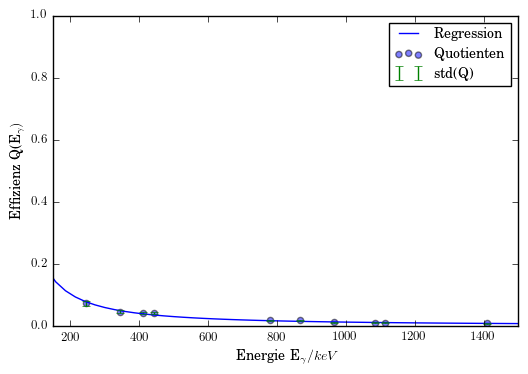

In [14]:
WWW = np.array([7.6, 26.5, 2.2, 3.1, 12.9, 4.2, 14.6, 10.2, 13.6, 21.0])/100 #Wechselwirkungswahrscheinlichkeit
lifetime = 3172 # Zeit in der Effekttiv ein Signal gemessen werden konnte
Q = EU.peak[1,1:]*4*np.pi/(Raumwinkel*AktEu*WWW*lifetime) #Effizienz
def pot(x,a, b):
    return a*(x)**(b)
print('Effizienz', Q)
paramsEffi = unumpy.uarray([params[0], params[1]],[std[0],std[1]])
params, cov = curve_fit(pot,unumpy.nominal_values(EU.peak[0,1:]), unumpy.nominal_values(Q), sigma=unumpy.std_devs(Q))
std = np.sqrt(np.diag(cov))
print("Fitparameter: a = ",paramsEffi[0] ,"b =", paramsEffi[1])
x = np.linspace(100,1500)
plt.plot(x, pot(x, *params), label='Regression')
plt.scatter(unumpy.nominal_values(EU.peak[0,1:]),un.nominal_values(Q), label='Quotienten', alpha=0.5)
plt.errorbar(unumpy.nominal_values(EU.peak[0,1:]),un.nominal_values(Q),yerr=unumpy.std_devs(Q), linestyle="None", label="std(Q)")
plt.xlabel(r"Energie E_\gamma / keV")
plt.ylabel(r"Effizienz Q(E_\gamma)")
plt.xlim(150,1500)
plt.ylim(0,1)
plt.legend(loc='best')
plt.savefig('./build/Effizienz.pdf')
plt.show()

# Cäsium
- Experimentell bestimmte Gamma Energie  $E_\gamma = 663.36 keV$ 
    - theo : $662 keV$
    - Natürliche Energie $\epsilon = \frac{E_\gamma}{m_0 c^2} = 1.2982$
- Experimentell bestimmter Rückstreupeak  $E_{Rück} = 470 keV$ 
    - theo : $E_\text{e,max} = E_\gamma \frac{2 \epsilon}{1 + 2 \epsilon} = E_\gamma 0.7219 = 478.87 keV $
- Auflösngsvermögen des Detektors
    - $\Delta E_{1/2}(663 keV) = 2.35 \sqrt{0.1 E_\gamma E_{EL}} = 1.03 keV$ 
    - Experimentell ermittelter $ = 1.46 keV $
        - Endliche Anzahl an Kanälen
        - Detektorbereich optimieren
    - Fehler Halbwertsbreite ~ 10-Wertsbreite = 2%

In [15]:
CS = makeSpek(Cs, scale=scaleing)
CS.stdGaus()
print(CS.peak[0,0])
epsilon = CS.peak[0,0]*10**3*constants.e/(constants.m_e*(constants.c**2))
print("Einheitenlose Energie epsilon: ", epsilon)
print("Rückstreupeak: ", CS.peak[0,0]*2*epsilon/(1+2*epsilon))
CS.corPeak(CS.peak[:,0])
# print(np.sqrt(2*np.pi)*(unumpy.std_devs(CS.peak)[0])*CS.peak[1])

663.4+/-0.6
Einheitenlose Energie epsilon:  1.2982+/-0.0012
Rückstreupeak:  478.9+/-0.6


Energie =  [663.3825116766244+/-0.60366520345373 2118.0+/-0]


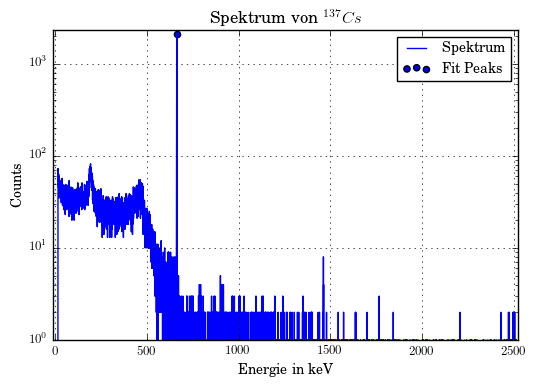

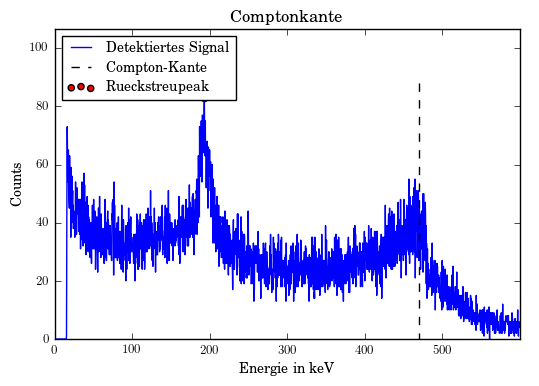

[663.3825116766244+/-0.60366520345373 2118.0+/-0]


In [16]:
CS = makeSpek(Cs, scale=scaleing, )
CS.stdGaus()
CS.corPeak(CS.peak[:,0])
print('Energie = ',CS.peak)
CS.plot(title="^{137}Cs",pathToSave="CS",scale='log')
CS.plotSector(smin=0,smax=600,title="Comptonkante", show=False)
plt.scatter(193,83,c='r', label='Rueckstreupeak')
plt.plot((470,470),(88,0),'k--', label='Compton-Kante')
plt.legend(loc='best')
plt.savefig("./build/Compton.pdf")
plt.show()
print(CS.peak)

In [17]:
mask = CS.xaxis<=478
print("Inhalt des Comptonkontinums: ", sum(CS.data[mask]))
print("Inhalt des Photopeaks: ", sum(CS.hits))

Inhalt des Comptonkontinums:  49956.0
Inhalt des Photopeaks:  (1.055+/-0.008)e+04


Die 10 Wertsbreite beträgt :  [ 2.59919624]


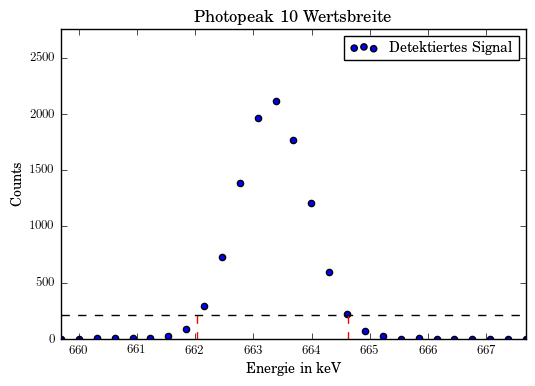

Die 2 Wertsbreite beträgt :  [ 1.45621652]


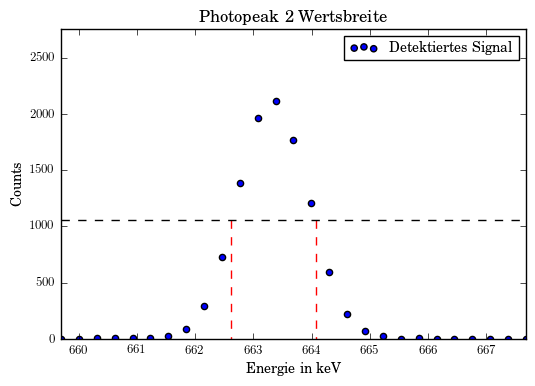

Verhältniss der beiden Breite [ 1.78489682]


In [18]:
a = CS.percentWidth(width=10,smin=660,smax=668, title="Photopeak 10 Wertsbreite",pathToSave="10", plotStyle=plt.scatter)
b = CS.percentWidth(width=2,smin=660,smax=668, title="Photopeak 2 Wertsbreite",pathToSave="2", plotStyle=plt.scatter)
print('Verhältniss der beiden Breite', a/b)

- Länge des Detektorchristall = 3.85 cm 
- Germanium
    - Dichte 5323 $kg/m^3$
    - z Kernladungszahl = 32
    - A Atomgewicht = 72.63 u (u = 1.66E^-27kg)
    - $N_L = 2.68E(25)$
    - $\sigma_{Photo}(600 keV) = 0.01$
    - $\sigma_{Compton}(600 keV) = 0.04$
- $\mu = n \sigma = \frac{z N_L \rho}{A} \sigma = 319$
- $N(D) = N_0 e^{-\mu D} = N_0 * 4.636E-6  $

In [19]:
print(sum(CS.data[:2180])/2740)

23.9343065693


# Aktivitätsbestimmung Barium
- Intensitäten = Zählergebniss

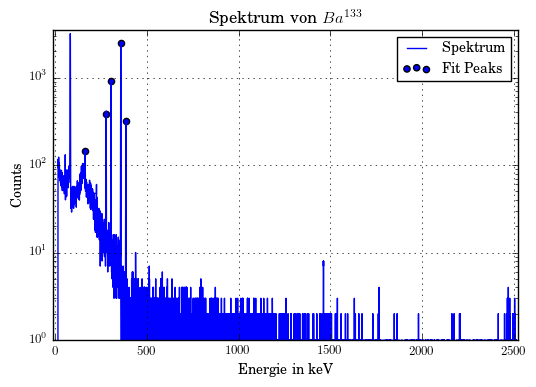

[2198.319317634169+/-385.7351133526492
 1762.9435640367933+/-57.579771525468686
 3553.2359215214615+/-64.28303396208504
 10117.72324059262+/-76.36765968179466
 1392.4642080999386+/-25.364035599400676]


In [20]:
BA = makeSpek(Ba, scale=scaleing)
BA.corPeak(BA.peak[:,1:-1])
BA.corPeak(np.append(BA.peak, np.array([[278],[380]]), axis=1))
BA.corPeak(np.append(BA.peak, np.array([[386],[320]]), axis=1))
BA.corPeak(BA.peak[:,1:])
BA.stdGaus()
BA.plot('Ba','Ba^{133}','log')
print(BA.hits)

In [21]:
baW = np.array([0.6, 7.16, 18.3, 62.1, 8.9])/100 #Emmisionewahrscheinlichkeit der Spektralline
print(BA.peak)
baQ = pot(BA.peak[0], *params) # Effizienz bei den entsprechenden Energien
BA.hits = np.array([])
BA.stdGaus(False)
lifetime = 3595
baA = BA.hits/(Raumwinkel*lifetime*baW*baQ) # Aktivität der verwendeten Bariumquelle
for x in range(len(BA.peak[1,:])):
    print(x, ': Zählergebnis: ', BA.hits[x], "    Energie: ", BA.peak[0,x])
    print("    Aktivität:", baA[x], "Effizienz: ", baQ[x])
    print("_____")
baA = np.append(baA[0],baA[2:]) #Wert 2 wird vernachlässigt weil er viel zu Groß ausfällt
print('Gemittelte Aktivität', np.mean(unumpy.nominal_values(baA[1:])), stats.sem(unumpy.nominal_values(baA[1:])))

[[162.69908893503512+/-2.567151724407506 278.0+/-0.5083214834667695
  304.83055719337716+/-0.45962912602019795
  357.9379956570773+/-0.49217349496313745 386.0+/-0.5216987659013401]
 [144.0+/-0 380 918.0+/-0 2509.0+/-0 320]]
0 : Zählergebnis:  (2.2+/-0.4)e+03     Energie:  162.7+/-2.6
    Aktivität: (3.9+/-0.8)e+03 Effizienz:  0.1346+/-0.0029
_____
1 : Zählergebnis:  (1.76+/-0.06)e+03     Energie:  278.0+/-0.5
    Aktivität: (5.4+/-0.6)e+02 Effizienz:  0.06454+/-0.00016
_____
2 : Zählergebnis:  (3.55+/-0.06)e+03     Energie:  304.8+/-0.5
    Aktivität: (4.8+/-0.5)e+02 Effizienz:  0.05687+/-0.00012
_____
3 : Zählergebnis:  (1.012+/-0.008)e+04     Energie:  357.9+/-0.5
    Aktivität: (5.1+/-0.5)e+02 Effizienz:  0.04562+/-0.00009
_____
4 : Zählergebnis:  1392+/-25     Energie:  386.0+/-0.5
    Aktivität: (5.4+/-0.6)e+02 Effizienz:  0.04113+/-0.00008
_____
Gemittelte Aktivität 510.889442948 16.0893843087


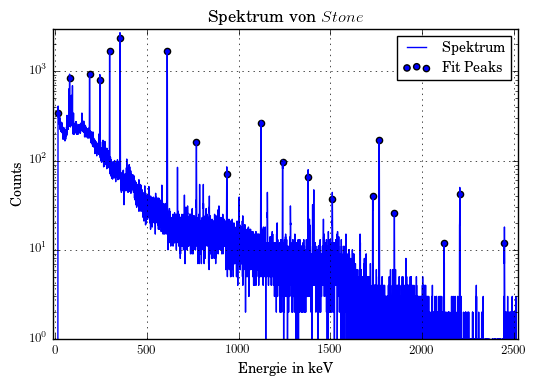

15.0+/-1.8
77.3+/-3.0
186.0+/-0.9
242.1+/-0.6
295.2+/-0.5
352.0+/-0.5
609.3+/-0.6
768.3+/-0.8
934.1+/-1.0
1120.4+/-0.7
1238.3+/-0.8
1377.7+/-0.8
1509.3+/-1.2
1729.8+/-0.9
1764.4+/-0.9
1847.3+/-1.0
2118.7+/-1.2
2204.0+/-0.9
2447.5+/-0.7


In [22]:
ST = makeSpek(St, scale=scaleing)
ST.plot('St','Stone','log')
ST.stdGaus()
x = ST.peak[0,:]+caliBios
for a in x:
    print(a)

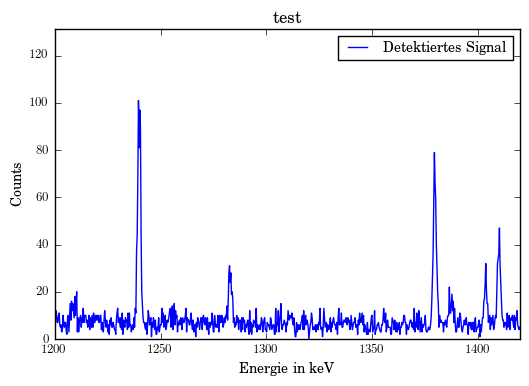

In [23]:
ST.plotSector(smin=1200, smax=1420)